In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

In [2]:
nifty50 = pd.read_csv("MW-NIFTY-50-16-Feb-2025.csv")

In [3]:
tickers = nifty50['SYMBOL \n'].unique()
tickers = [i + '.NS' for i in tickers]
tickers.remove('NIFTY 50.NS')

In [4]:
stock_prices = yf.download(tickers,start='2023-01-01',end='2025-01-01')['Close']
stock_returns = np.log(stock_prices / stock_prices.shift(1)).dropna()
print(stock_returns.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  50 of 50 completed

Ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
Date                                                                   
2023-01-03    -0.002672      -0.002252       0.008172      -0.006255   
2023-01-04    -0.001019      -0.012819      -0.012909      -0.003772   
2023-01-05     0.000718       0.011782      -0.000959      -0.004152   
2023-01-06    -0.001450      -0.016609      -0.009437      -0.008675   
2023-01-09     0.008086       0.013003       0.004605       0.001929   

Ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
Date                                                                   
2023-01-03     0.021746       0.007735       0.006740       0.007979   
2023-01-04    -0.005053      -0.013656      -0.009740      -0.005350   
2023-01-05    -0.008285       0.019041      -0.052387      -0.074369   
2023-01-06    -0.010215       0.005810      -0.026561      -0.019809   
2023-01-09     0.019857      -0.005920      -0.011497       0.0

In [5]:
def implement_and_visualize_pca(returns_df, n_components=None):
    """
    Apply PCA to stock returns data and visualize the results.
    
    Parameters:
    -----------
    returns_df : pandas.DataFrame
        DataFrame containing stock returns with shape (n_samples, n_stocks)
    n_components : int, optional
        Number of principal components to keep. If None, all components are kept.
        
    Returns:
    --------
    pca_model : sklearn.decomposition.PCA
        The fitted PCA model
    transformed_returns : pandas.DataFrame
        Returns data transformed into principal component space
    """
    # Standardize returns (important for PCA)
    returns_std = (returns_df - returns_df.mean()) / returns_df.std()
    
    # Apply PCA
    pca_model = PCA(n_components=n_components)
    transformed_data = pca_model.fit_transform(returns_std)
    
    # Create DataFrame for transformed data
    transformed_returns = pd.DataFrame(
        transformed_data,
        index=returns_df.index,
        columns=[f'PC{i+1}' for i in range(transformed_data.shape[1])]
    )
    
    # Visualize explained variance
    plt.figure(figsize=(12, 6))
    
    # Plot explained variance ratio
    plt.subplot(1, 2, 1)
    explained_var = pca_model.explained_variance_ratio_
    plt.bar(range(1, len(explained_var) + 1), explained_var)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')
    plt.xticks(range(1, len(explained_var) + 1))
    
    # Plot cumulative explained variance
    plt.subplot(1, 2, 2)
    cum_explained_var = np.cumsum(explained_var)
    plt.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.xticks(range(1, len(cum_explained_var) + 1))
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Visualize first two principal components
    if transformed_data.shape[1] >= 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('Stock Returns Projected onto First Two Principal Components')
        plt.grid(True)
        plt.show()
    
    # Visualize component weights
    n_display = min(10, pca_model.components_.shape[1])
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pca_model.components_[:5, :n_display], 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm',
        xticklabels=returns_df.columns[:n_display],
        yticklabels=[f'PC{i+1}' for i in range(5)]
    )
    plt.title('Weights of First 5 Principal Components (Top 10 Stocks)')
    plt.tight_layout()
    plt.show()
    
    # Print variance explained information
    n_components_95 = np.argmax(cum_explained_var >= 0.95) + 1
    print(f"Number of components needed to explain 95% of variance: {n_components_95}")
    print(f"Total number of components: {len(explained_var)}")
    
    return pca_model, transformed_returns

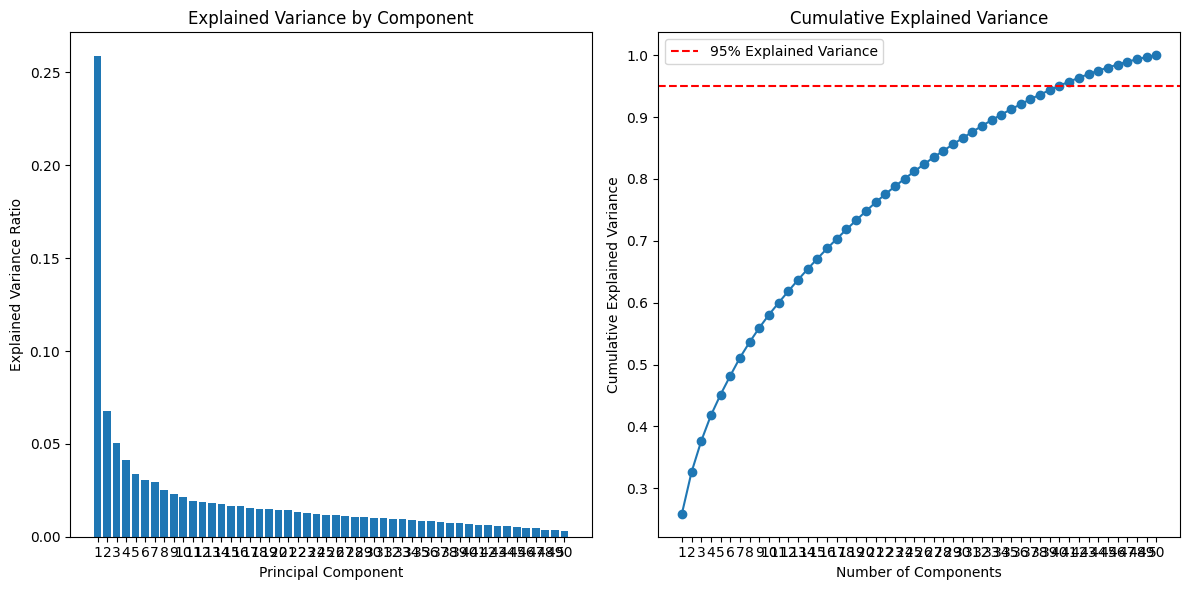

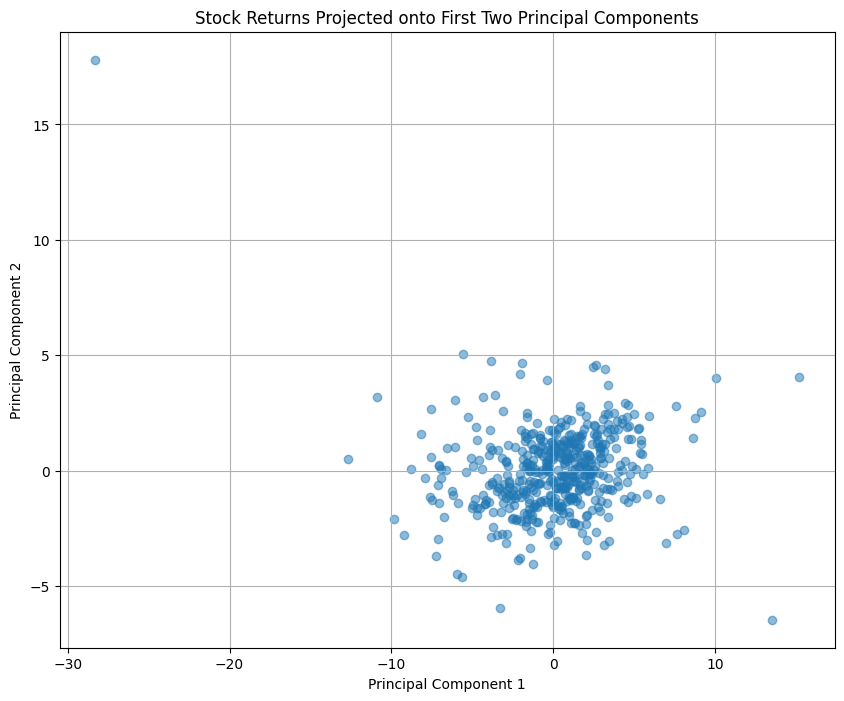

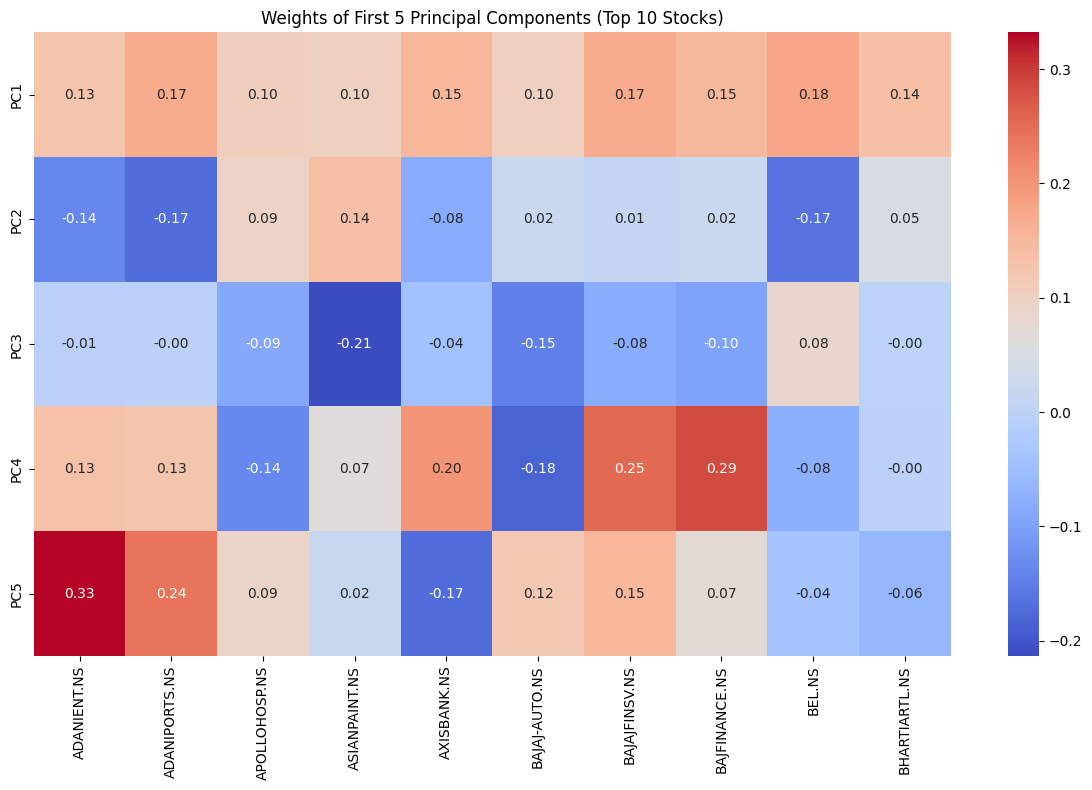

Number of components needed to explain 95% of variance: 40
Total number of components: 50


In [6]:
pca_model, transformed_returns = implement_and_visualize_pca(stock_returns)

In [11]:
def optimize_portfolio_with_pca(returns_df, n_components=None, min_weight=0.01, 
                              max_weight=0.2, target_risk=None, risk_aversion=1,
                              group_constraints=None, target_diversification=0.5,
                              robust_cov=True):
    """
    Perform portfolio optimization using PCA for dimensionality reduction.
    
    Parameters:
    -----------
    returns_df : pandas.DataFrame
        DataFrame containing stock returns
    n_components : int or float, optional
        If int: Number of principal components to keep
        If float (0-1): Proportion of variance to retain
        If None: Components explaining 95% of variance are kept
    min_weight : float
        Minimum weight allowed for any asset
    max_weight : float
        Maximum weight allowed for any asset
    target_risk : float, optional
        Target portfolio volatility (annualized). If provided, overrides risk_aversion.
    risk_aversion : float
        Risk aversion parameter for mean-variance utility when target_risk is None
    group_constraints : dict, optional
        Dictionary mapping group names to lists of asset indices, with max weights.
        Example: {'Tech': {'assets': [0, 1, 3], 'max_weight': 0.3}}
    target_diversification : float
        Target for effective number of assets (1/HHI) as a fraction of total assets.
        E.g., 0.5 means effectively use 50% of available assets. Default is 0.5.
    robust_cov : bool
        Whether to use robust covariance estimation (shrinkage estimator). Default is True.
        
    Returns:
    --------
    weights : numpy.ndarray
        Optimized portfolio weights
    pca_model : sklearn.decomposition.PCA
        The fitted PCA model
    performance : dict
        Performance metrics of the optimized portfolio
    """
    import numpy as np
    import cvxpy as cp
    from sklearn.decomposition import PCA
    from sklearn.covariance import LedoitWolf
    
    # Get original returns statistics
    n_assets = returns_df.shape[1]
    mean_returns = returns_df.mean().values
    
    # Use robust covariance if specified
    if robust_cov:
        lw = LedoitWolf()
        lw.fit(returns_df.values)
        cov_matrix = lw.covariance_
        print("Using Ledoit-Wolf shrinkage estimator for covariance")
    else:
        cov_matrix = returns_df.cov().values
    
    # Apply PCA
    if n_components is None:
        # Initialize PCA to retain enough components to explain 95% variance
        pca_model = PCA(n_components=0.95)
    elif isinstance(n_components, float) and 0 < n_components < 1:
        # Variance threshold provided
        pca_model = PCA(n_components=n_components)
    else:
        # Specific number of components
        pca_model = PCA(n_components=n_components)
    
    # Standardize returns before applying PCA
    returns_std = (returns_df - returns_df.mean()) / returns_df.std()
    pca_model.fit(returns_std)
    
    # Get number of components used
    n_pca = pca_model.n_components_
    print(f"Using {n_pca} principal components explaining {sum(pca_model.explained_variance_ratio_)*100:.2f}% of variance")
    
    # Get PCA components and eigenvalues
    components = pca_model.components_  # shape: (n_pca, n_assets)
    explained_var = pca_model.explained_variance_
    
    # Create a PCA-regularized covariance matrix
    # This is a low-rank approximation of the full covariance
    pca_cov = components.T @ np.diag(explained_var) @ components
    
    # Set up optimization in original space but with PCA regularization
    w = cp.Variable(n_assets)
    
    # Define objective function
    if target_risk is not None:
        # Target risk approach with PCA-regularized risk
        ann_factor = 252  # Assuming daily returns
        target_var = (target_risk / np.sqrt(ann_factor))**2
        
        # Maximize return subject to risk constraint
        objective = cp.Maximize(mean_returns @ w)
        risk_constraint = cp.quad_form(w, pca_cov) <= target_var
    else:
        # Mean-variance utility with PCA regularization
        risk = cp.quad_form(w, pca_cov)
        objective = cp.Maximize(mean_returns @ w - risk_aversion * risk)
        risk_constraint = None
    
    # Basic constraints
    constraints = [
        cp.sum(w) == 1,          # Fully invested
        w >= min_weight,         # Minimum weight
        w <= max_weight          # Maximum weight
    ]
    
    # Add risk constraint if applicable
    if risk_constraint is not None:
        constraints.append(risk_constraint)
    
    # Add group constraints if provided
    if group_constraints is not None:
        for group_name, group_info in group_constraints.items():
            group_assets = group_info['assets']
            max_group_weight = group_info['max_weight']
            constraints.append(cp.sum(w[group_assets]) <= max_group_weight)
    
    # Add constraint on diversification if specified
    if target_diversification is not None:
        # Constraint on sum of squared weights to control concentration
        # Lower sum of squares = higher diversification
        max_sum_squared = 1 / (target_diversification * n_assets)
        constraints.append(cp.sum_squares(w) <= max_sum_squared)
    
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    
    try:
        problem.solve()
    except Exception as e:
        print(f"Optimization failed: {e}")
        print("Trying alternative solver...")
        try:
            problem.solve(solver=cp.SCS)
        except:
            print("All solvers failed. Falling back to equal weights.")
            return np.ones(n_assets) / n_assets, pca_model, {}
    
    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")
        print("Trying a simpler formulation...")
        
        # Try a simpler approach: minimize PCA-regularized risk
        w_simple = cp.Variable(n_assets)
        risk_simple = cp.quad_form(w_simple, pca_cov)
        obj_simple = cp.Minimize(risk_simple)
        
        constraints_simple = [
            cp.sum(w_simple) == 1,
            w_simple >= min_weight,
            w_simple <= max_weight
        ]
        
        problem_simple = cp.Problem(obj_simple, constraints_simple)
        
        try:
            problem_simple.solve()
            if problem_simple.status == 'optimal':
                weights = w_simple.value
            else:
                print("Simple optimization failed. Using equal weights.")
                weights = np.ones(n_assets) / n_assets
        except:
            print("Simple optimization failed. Using equal weights.")
            weights = np.ones(n_assets) / n_assets
    else:
        weights = w.value
    
    # If we have a solution, ensure weights sum to 1 (fix numerical issues)
    if weights is not None:
        weights = weights / np.sum(weights)
    else:
        # Fall back to equal weights if everything failed
        weights = np.ones(n_assets) / n_assets
    
    # Calculate performance metrics
    expected_return = mean_returns @ weights
    volatility = np.sqrt(weights @ cov_matrix @ weights)
    pca_volatility = np.sqrt(weights @ pca_cov @ weights)
    sharpe_ratio = expected_return / volatility
    
    # Calculate diversification metrics
    hhi = np.sum(weights**2)  # Herfindahl-Hirschman Index
    effective_n = 1 / hhi     # Effective number of assets
    
    performance = {
        'Expected Return': expected_return,
        'Volatility': volatility,
        'PCA Volatility': pca_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'HHI': hhi,
        'Effective N': effective_n
    }
    
    # Print key metrics
    ann_factor = 252  # Assuming daily returns
    print(f"Expected Return (annualized): {expected_return*ann_factor:.4f}")
    print(f"Volatility (annualized): {volatility*np.sqrt(ann_factor):.4f}")
    print(f"Sharpe Ratio (annualized): {sharpe_ratio*np.sqrt(ann_factor):.4f}")
    print(f"Effective Number of Assets: {effective_n:.2f} out of {n_assets}")
    
    # Calculate number of active positions (weights > threshold)
    active_threshold = 1.5 * min_weight
    active_positions = np.sum(weights > active_threshold)
    print(f"Active Positions: {active_positions} (weight > {active_threshold:.4f})")
    
    return weights, pca_model, performance


In [17]:
pca_weights, _, pca_performance = optimize_portfolio_with_pca(
        stock_returns, 
        n_components=None,  # Automatically select components explaining 95% variance
        min_weight=0.01, 
        max_weight=0.15,
    target_diversification = 0.5
    )

Using Ledoit-Wolf shrinkage estimator for covariance
Using 40 principal components explaining 95.08% of variance
Expected Return (annualized): 0.1865
Volatility (annualized): 0.1123
Sharpe Ratio (annualized): 1.6601
Effective Number of Assets: 25.00 out of 50
Active Positions: 14 (weight > 0.0150)


In [18]:
def compare_optimization_methods(returns_df, n_components=None, min_weight=0.01, 
                              max_weight=0.2, risk_aversion=1):
    """
    Compare PCA-based portfolio optimization with standard mean-variance optimization.
    
    Parameters:
    -----------
    returns_df : pandas.DataFrame
        DataFrame containing stock returns
    n_components : int, optional
        Number of principal components to use for PCA optimization
    min_weight : float
        Minimum weight allowed for any asset
    max_weight : float
        Maximum weight allowed for any asset
    risk_aversion : float
        Risk aversion parameter for mean-variance utility
        
    Returns:
    --------
    comparison : dict
        Dictionary containing weights and performance metrics for both methods
    """
    # 1. PCA-Based Optimization
    pca_weights, pca_model, pca_performance = optimize_portfolio_with_pca(
        returns_df, 
        n_components=n_components, 
        min_weight=min_weight,
        max_weight=max_weight,
        risk_aversion=risk_aversion
    )
    
    # 2. Standard Mean-Variance Optimization
    n_assets = returns_df.shape[1]
    mean_returns = returns_df.mean().values
    cov_matrix = returns_df.cov().values
    
    # Define the optimization problem
    w = cp.Variable(n_assets)
    
    # Define objective function (mean-variance utility)
    risk = cp.quad_form(w, cov_matrix)
    expected_return = mean_returns @ w
    
    objective = cp.Maximize(expected_return - risk_aversion * risk)
    
    # Define constraints
    constraints = [
        cp.sum(w) == 1,          # Fully invested
        w >= min_weight,         # Minimum weight
        w <= max_weight          # Maximum weight
    ]
    
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Get the optimal weights
    mv_weights = w.value
    
    # Calculate performance metrics for mean-variance portfolio
    mv_expected_return = mean_returns @ mv_weights
    mv_volatility = np.sqrt(mv_weights @ cov_matrix @ mv_weights)
    mv_sharpe_ratio = mv_expected_return / mv_volatility
    
    mv_performance = {
        'Expected Return': mv_expected_return,
        'Volatility': mv_volatility,
        'Sharpe Ratio': mv_sharpe_ratio
    }
    
    # Compare the weights and performance
    plt.figure(figsize=(12, 10))
    
    # Plot the weights
    plt.subplot(2, 1, 1)
    x = np.arange(n_assets)
    width = 0.35
    
    plt.bar(x - width/2, pca_weights, width, label='PCA-Based')
    plt.bar(x + width/2, mv_weights, width, label='Mean-Variance')
    
    plt.xlabel('Stocks')
    plt.ylabel('Weight')
    plt.title('Portfolio Weights Comparison')
    plt.xticks(x, returns_df.columns, rotation=90)
    plt.legend()
    
    # Plot performance metrics
    plt.subplot(2, 1, 2)
    metrics = ['Expected Return', 'Volatility', 'Sharpe Ratio']
    pca_metrics = [pca_performance[m] for m in metrics]
    mv_metrics = [mv_performance[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, pca_metrics, width, label='PCA-Based')
    plt.bar(x + width/2, mv_metrics, width, label='Mean-Variance')
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate weight differences and concentration measures
    weight_diff = np.abs(pca_weights - mv_weights).sum() / 2  # Sum of absolute differences divided by 2
    
    pca_concentration = np.sum(pca_weights**2)  # Herfindahl-Hirschman Index for PCA weights
    mv_concentration = np.sum(mv_weights**2)    # Herfindahl-Hirschman Index for MV weights
    
    print(f"Weight difference (sum of absolute differences / 2): {weight_diff:.4f}")
    print(f"PCA portfolio concentration (HHI): {pca_concentration:.4f}")
    print(f"Mean-Variance portfolio concentration (HHI): {mv_concentration:.4f}")
    
    # Return the comparison results
    comparison = {
        'PCA Weights': pca_weights,
        'Mean-Variance Weights': mv_weights,
        'PCA Performance': pca_performance,
        'Mean-Variance Performance': mv_performance,
        'Weight Difference': weight_diff,
        'PCA Concentration': pca_concentration,
        'MV Concentration': mv_concentration
    }
    
    return comparison


Using Ledoit-Wolf shrinkage estimator for covariance
Using 40 principal components explaining 95.08% of variance
Expected Return (annualized): 0.1862
Volatility (annualized): 0.1124
Sharpe Ratio (annualized): 1.6565
Effective Number of Assets: 25.04 out of 50
Active Positions: 14 (weight > 0.0150)


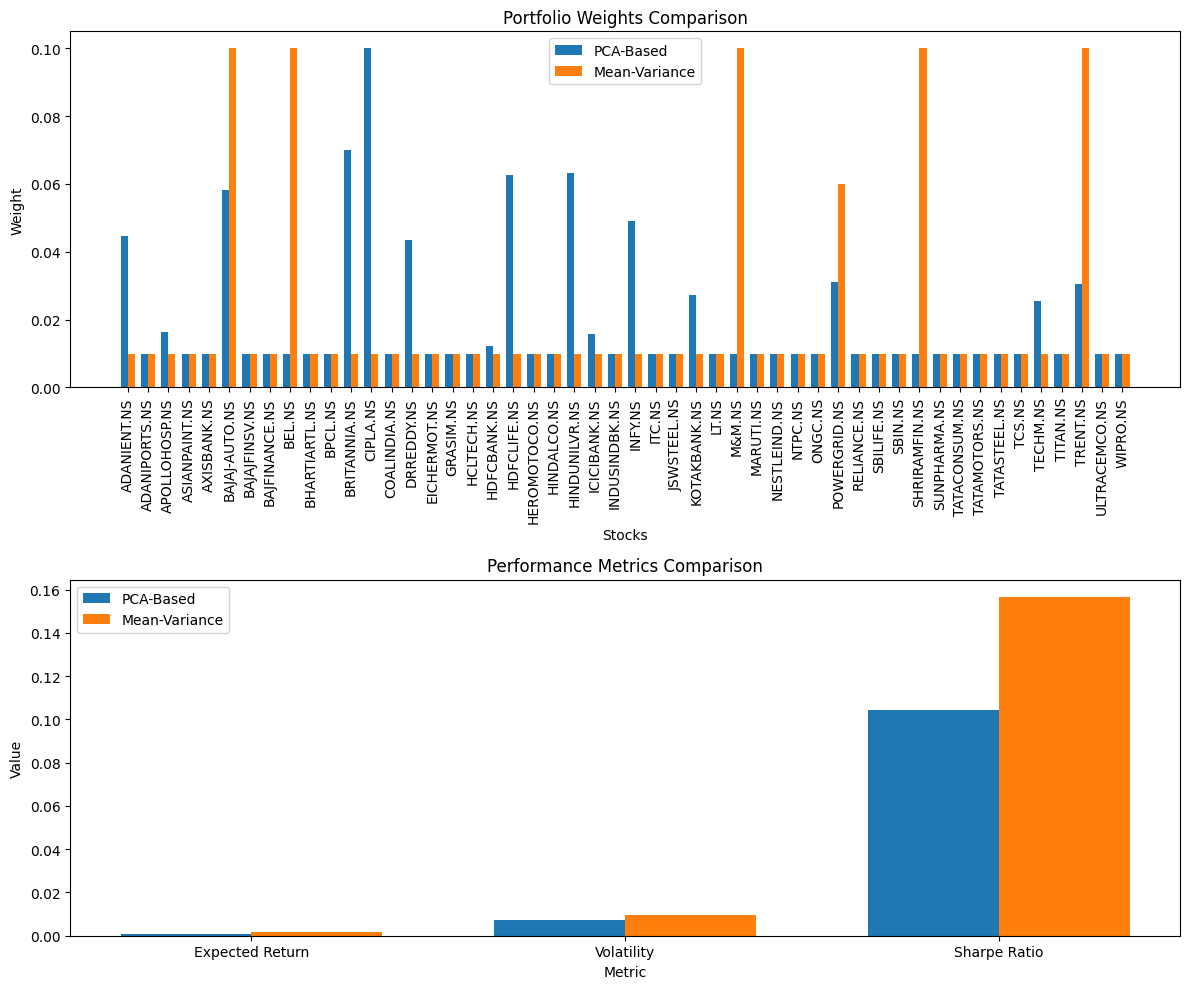

Weight difference (sum of absolute differences / 2): 0.4100
PCA portfolio concentration (HHI): 0.0399
Mean-Variance portfolio concentration (HHI): 0.0580


In [19]:
comparison = compare_optimization_methods(
        stock_returns,
        n_components=None,  # Automatically select components explaining 95% variance
        min_weight=0.01,
        max_weight=0.1
    )